In [1]:
# import the necessary packages
import matplotlib
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from keras.models import load_model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.models import Model
from keras import layers
from keras import backend as K
from keras import metrics
from keras.utils import np_utils
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import imutils
from imutils import paths
import random
import pickle
import heapq
import cv2
import os
import csv
import ast

Using TensorFlow backend.


In [2]:
def build_nottrainable_VGG16(classes,shape,activation_type):
    model = VGG16(include_top=False, weights='imagenet',input_shape=(shape,shape,3))
    transfer_layer = model.get_layer('block5_pool')
    conv_model = Model(inputs=model.input,outputs=transfer_layer.output)
    #conv_model.trainable = False
    for layer in conv_model.layers:
        layer.trainable = False

    new_model = Sequential()
    new_model.add(conv_model)
    #Flatten the output of the VGG16 model because its from Conv Layer		
    new_model.add(layers.Flatten())
    #Add a dense fully connected layer
    new_model.add(layers.Dense(1024, activation = 'relu'))
    new_model.add(layers.Dropout(0.5))
    new_model.add(layers.Dense(classes, activation = activation_type))

    # return the constructed network architecture
    return new_model

def build_trainable_VGG16(classes,shape,activation_type):
    model = VGG16(include_top=False, weights='imagenet',input_shape=(shape,shape,3))
    transfer_layer = model.get_layer('block5_pool')
    conv_model = Model(inputs=model.input,outputs=transfer_layer.output)
    #conv_model.trainable = False
    for layer in conv_model.layers[:-1]:
        layer.trainable = False
    new_model = Sequential()
    new_model.add(conv_model)
    #Flatten the output of the VGG16 model because its from Conv Layer		
    new_model.add(layers.Flatten())
    #Add a dense fully connected layer
    new_model.add(layers.Dense(1024, activation = 'relu'))
    new_model.add(layers.Dropout(0.5))
    new_model.add(layers.Dense(classes, activation = activation_type))

    # return the constructed network architecture
    return new_model

In [3]:
def build_smallvgg(classes,shape,activation_type):
    model = Sequential()
    inputShape = (shape,shape,3)
    chanDim = -1

    # CONV => RELU => POOL
    model.add(Conv2D(32, (3, 3), padding="same",
        input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.25))

    # (CONV => RELU) * 2 => POOL
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # (CONV => RELU) * 2 => POOL
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # sigmoid classifier
    model.add(Dense(classes))
    model.add(Activation(activation_type))
    
    return model

In [4]:
def UnionBox(x1,x2,y1,y2,h1,h2,w1,w2):
    ub_x = 0
    ub_y = 0
    ub_w = 0
    ub_h = 0

    if x1 > x2:
        ub_x = x2
    else:
        ub_x = x1

    if y1 > y2:
        ub_y = y2
    else:
        ub_y = y1

    if x1+w1 > x2+w2:
        ub_w = x1+w1-ub_x
    else:
        ub_w = x2+w2-ub_x

    if y1+h1 > y2+h2:
        ub_h = y1+h1-ub_y
    else:
        ub_h = y2+h2-ub_y
        
    return ub_x,ub_y,ub_w,ub_h

In [5]:
def crop_image(img_arr,ub_y,ub_x,ub_w,ub_h):
    #crop the image with the union box and return it
    crop_img = img_arr[ub_y:ub_y+ub_h, ub_x:ub_x+ub_w].copy()
    return crop_img

In [6]:
def Union_WB_B_Seperate(height,width,x1,y1,h1,w1,x2,y2,h2,w2):
    #Create a new array, of 0's with height and width
    #Sets to Green
    img_array1 = np.zeros((int(height),int(width),3), np.uint8)
    img_array1[int(y1):int(y1+h1), int(x1):int(x1+w1)] = (0,255,0)
    g = img_array1.copy()
    #Split the image only taking the green channel
    b1,g1,r1 = cv2.split (g)
    img_array2 = np.zeros((int(height),int(width),3), np.uint8)
    img_array2[int(y2):int(y2+h2), int(x2):int(x2+w2)] = (255,0,0)
    b = img_array2.copy()
    #Split blue image take only  blue channel
    b2,g2,r2 = cv2.split (b)
    #Merge the image
    new_img = cv2.merge((b2,g1,r2))
    ub_x,ub_y,ub_w,ub_h = UnionBox(x1,x2,y1,y2,h1,h2,w1,w2)
    crop_img = crop_image(new_img.copy(),ub_y,ub_x,ub_w,ub_h)
    return crop_img

In [7]:
def csv_image_generator_multilabel(size,inputPath, bs, mlb, mode, aug=None):
    # open the CSV file for reading
    with open(inputPath, 'r') as f1:
        reader = csv.reader(f1)
        your_list = list(reader)
    f1.close()
    i = 0
    # loop indefinitely	
    while True:
        # initialize our batches of images and labels
        images = []
        labels = []
        # keep looping until we reach our batch size
        while len(images) < bs and i < len(your_list):

            #if mode == "eval" and i ==  len(your_list):
            #    break
            
            #Get the labels
            x = ast.literal_eval(your_list[i][0])
            x = [n.strip() for n in x]
            labels.append(x)
            
            #Get image information and create the image
            width  = your_list[i][1]
            height  = your_list[i][2]
    
            bb1 = ast.literal_eval(your_list[i][3])
            bb1 = [int(n) for n in bb1]
            
            x1 = abs(bb1[0])
            y1 = abs(bb1[1])
            w1 = abs(bb1[2])
            h1 = abs(bb1[3])
            
            bb2 = ast.literal_eval(your_list[i][4])
            bb2 = [int(n) for n in bb2]
            
            x2 = abs(bb2[0])
            y2 = abs(bb2[1])
            w2 = abs(bb2[2])
            h2 = abs(bb2[3])
            
            image = Union_WB_B_Seperate(height,width,x1,y1,h1,w1,x2,y2,h2,w2)
            #print(image.shape)
            image = cv2.resize(image, (size, size))
            image = img_to_array(image)
            #update our corresponding batches lists
            images.append(image)
            i += 1
        #print(i)
        if mode == "train" and i == len(your_list):
            i = 0
        #print(mode,i)
        elif mode == "eval" and i == len(your_list):
            print("THIS IS BEING REACHED")
            #break
            
        images = np.array(images, dtype="float") /255.0
        labels = np.array(labels)
        labels = mlb.transform(labels)
        # yield the batch to the calling function
        yield (images, labels)

In [8]:
def csv_image_generator_multilabel_predictor(size,inputPath, bs):
    # open the CSV file for reading
    with open(inputPath, 'r') as f1:
        reader = csv.reader(f1)
        your_list = list(reader)
    f1.close()
    i = 0
    # loop indefinitely	
    while True:
        # initialize our batches of images and labels
        images = []
        # keep looping until we reach our batch size
        while len(images) < 1 and i < len(your_list):    
            #Get image information and create the image
            width  = your_list[i][1]
            height  = your_list[i][2]
    
            bb1 = ast.literal_eval(your_list[i][3])
            bb1 = [int(n) for n in bb1]
            
            x1 = abs(bb1[0])
            y1 = abs(bb1[1])
            w1 = abs(bb1[2])
            h1 = abs(bb1[3])
            
            bb2 = ast.literal_eval(your_list[i][4])
            bb2 = [int(n) for n in bb2]
            
            x2 = abs(bb2[0])
            y2 = abs(bb2[1])
            w2 = abs(bb2[2])
            h2 = abs(bb2[3])
            
            image = Union_WB_B_Seperate(height,width,x1,y1,h1,w1,x2,y2,h2,w2)
            #print(image.shape)
            image = cv2.resize(image, (size, size))
            image = img_to_array(image)
            #update our corresponding batches lists
            images.append(image)
            i += 1
        if i >= len(your_list):
            print("OverBoard")
        images = np.array(images, dtype="float") /255.0
        yield (images)

In [9]:
def csv_image_generator_singlelabel(size,inputPath, bs, mlb, mode, aug=None):
    # open the CSV file for reading
    with open(inputPath, 'r') as f1:
        reader = csv.reader(f1)
        your_list = list(reader)
    f1.close()
    i = 0
    # loop indefinitely	
    while True:
        # initialize our batches of images and labels
        images = []
        labels = []
        # keep looping until we reach our batch size
        while len(images) < bs and i < len(your_list):

            #if mode == "eval" and i ==  len(your_list):
            #    break
            
            #Get the labels
            x = ast.literal_eval(str([your_list[i][0]]))
            x = [n.strip() for n in x]
            labels.append(x[0])
            
            #Get image information and create the image
            width  = your_list[i][1]
            height  = your_list[i][2]
    
            bb1 = ast.literal_eval(your_list[i][3])
            bb1 = [int(n) for n in bb1]
            
            x1 = abs(bb1[0])
            y1 = abs(bb1[1])
            w1 = abs(bb1[2])
            h1 = abs(bb1[3])
            
            bb2 = ast.literal_eval(your_list[i][4])
            bb2 = [int(n) for n in bb2]
            
            x2 = abs(bb2[0])
            y2 = abs(bb2[1])
            w2 = abs(bb2[2])
            h2 = abs(bb2[3])
            
            image = Union_WB_B_Seperate(height,width,x1,y1,h1,w1,x2,y2,h2,w2)
            #print(image.shape)
            image = cv2.resize(image, (size, size))
            image = img_to_array(image)
            #update our corresponding batches lists
            images.append(image)
            i += 1
        #print(i)
        if mode == "train" and i == len(your_list):
            i = 0
        #print(mode,i)
        elif mode == "eval" and i == len(your_list):
            print("THIS IS BEING REACHED")
            #break
            
        images = np.array(images, dtype="float") /255.0
        labels = np.array(labels)
        labels = mlb.transform(labels)
        # yield the batch to the calling function
        yield (images, labels)

In [10]:
def extract_mlb_multilabel(dir_out,TRAIN_CSV,TEST_CSV,VAL_CSV):
    
    labels = []
    testLabels = []
    validLabels = []
    NUM_TRAIN_IMAGES = 0
    NUM_TEST_IMAGES = 0
    NUM_VAL_IMAGES = 0
    #Open training file
    with open(TRAIN_CSV, 'r') as f2:
        reader = csv.reader(f2)
        your_list = list(reader)
    f2.close()
    #Add all labels to the train label list
    for i in range(len(your_list)):
        x = ast.literal_eval(your_list[i][0])
        x = [n.strip() for n in x]
        labels.append(x)
        NUM_TRAIN_IMAGES += 1
        
    #Repeat for test and valid
    with open(TEST_CSV, 'r') as f3:
        reader = csv.reader(f3)
        your_list = list(reader)
    f3.close()
    
    for i in range(len(your_list)):
        x = ast.literal_eval(your_list[i][0])
        x = [n.strip() for n in x]
        testLabels.append(x)
        NUM_TEST_IMAGES += 1

    with open(VAL_CSV, 'r') as f4:
        reader = csv.reader(f4)
        your_list = list(reader)
    f4.close()

    for i in range(len(your_list)):
        x = ast.literal_eval(your_list[i][0])
        x = [n.strip() for n in x]
        validLabels.append(x)
        NUM_VAL_IMAGES += 1
    
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    testLabels = mlb.fit_transform(testLabels)
    validLabels = mlb.fit_transform(validLabels)
    
    output_dir = "pickle_models/"+dir_out
    # save the multi-label binarizer to disk
    print("[INFO] serializing label binarizer...")
    f = open(output_dir, "wb")
    f.write(pickle.dumps(mlb))
    f.close()
    
    return testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES

In [11]:
def extract_mlb_singlelabel(dir_out,TRAIN_CSV,TEST_CSV,VAL_CSV):
    
    labels = []
    testLabels = []
    validLabels = []
    NUM_TRAIN_IMAGES = 0
    NUM_TEST_IMAGES = 0
    NUM_VAL_IMAGES = 0
    #Open training file
    with open(TRAIN_CSV, 'r') as f2:
        reader = csv.reader(f2)
        your_list = list(reader)
    f2.close()
    #Add all labels to the train label list
    for i in range(len(your_list)):
        x = ast.literal_eval(str([your_list[i][0]]))
        x = [n.strip() for n in x]
        labels.append(x[0])
        NUM_TRAIN_IMAGES += 1
        
    #Repeat for test and valid
    with open(TEST_CSV, 'r') as f3:
        reader = csv.reader(f3)
        your_list = list(reader)
    f3.close()
    
    for i in range(len(your_list)):
        x = ast.literal_eval(str([your_list[i][0]]))
        x = [n.strip() for n in x]
        testLabels.append(x[0])
        NUM_TEST_IMAGES += 1

    with open(VAL_CSV, 'r') as f4:
        reader = csv.reader(f4)
        your_list = list(reader)
    f4.close()

    for i in range(len(your_list)):
        x = ast.literal_eval(str([your_list[i][0]]))
        x = [n.strip() for n in x]
        validLabels.append(x[0])
        NUM_VAL_IMAGES += 1

    mlb = LabelBinarizer()
    labels = mlb.fit_transform(labels)
    testLabels = mlb.fit_transform(testLabels)
    validLabels = mlb.fit_transform(validLabels)
    
    output_dir = "pickle_models/"+dir_out
    # save the multi-label binarizer to disk
    print("[INFO] serializing label binarizer...")
    f = open(output_dir, "wb")
    f.write(pickle.dumps(mlb))
    f.close()
    
    return testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES

In [12]:
def top_3_cat(y_true,y_pred):
    return metrics.top_k_categorical_accuracy(y_true,y_pred,3)

In [13]:
def train_model_multi(model_type,activation_type,shape,name,trainable,NUM_EPOCHS,learning_rate,weights,mlb,TRAIN_CSV,Val_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES):
    # initialize both the training and testing image generators
    trainGen = csv_image_generator_multilabel(shape,TRAIN_CSV, BS, mlb,
    mode="train", aug=None)
    valGen = csv_image_generator_multilabel(shape,Val_CSV, BS, mlb,
    mode="train", aug=None)
    
    if model_type == "VGG16":
        if trainable == True:
            model = build_trainable_VGG16(len(mlb.classes_),shape,activation_type)
        elif trainable == False:
            model = build_nottrainable_VGG16(len(mlb.classes_),shape,activation_type)
    elif model_type == "SmallVGG":
        model = build_smallvgg(len(mlb.classes_),shape,activation_type)
    else:
        print("FAILURE TO FIND MODEL TYPE")
        
    if weights != None:
        model.load_weights(weights)
    
    #Using binary cross entropy 
    opt = Adam(lr=learning_rate, decay=learning_rate / NUM_EPOCHS)
    
    model.compile(loss="binary_crossentropy", optimizer=opt,
        metrics=['categorical_accuracy',top_3_cat])
    
    # train the network
    print("[INFO] training w/ generator...")
    H = model.fit_generator(
        trainGen,
        steps_per_epoch=NUM_TRAIN_IMAGES // BS,
        validation_data=valGen,
        validation_steps=NUM_VAL_IMAGES // BS,
        epochs=NUM_EPOCHS)
    
    print("[INFO] plotting...")
    plot_name = "plots/"+name + "_plot.png"
    # plot the training loss and accuracy
    N = NUM_EPOCHS
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["categorical_accuracy"], label="categorical_accuracy")
    plt.plot(np.arange(0, N), H.history["val_categorical_accuracy"], label="val_categorical_accuracy")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plot_name)
    
    return model

In [14]:
def train_model_single(model_type,activation_type,shape,name,trainable,NUM_EPOCHS,learning_rate,weights,mlb,TRAIN_CSV,Val_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES):
    # initialize both the training and testing image generators
    trainGen = csv_image_generator_singlelabel(shape,TRAIN_CSV, BS, mlb,
    mode="train", aug=None)
    valGen = csv_image_generator_singlelabel(shape,Val_CSV, BS, mlb,
    mode="train", aug=None)
    
    if model_type == "VGG16":
        if trainable == True:
            model = build_trainable_VGG16(len(mlb.classes_),shape,activation_type)
        elif trainable == False:
            model = build_nottrainable_VGG16(len(mlb.classes_),shape,activation_type)
    elif model_type == "SmallVGG":
        model = build_smallvgg(len(mlb.classes_),shape,activation_type)
    else:
        print("FAILURE TO FIND MODEL TYPE")
        
    if weights != None:
        model.load_weights(weights)
    
    #Using binary cross entropy 
    opt = Adam(lr=learning_rate, decay=learning_rate / NUM_EPOCHS)
    model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=['accuracy'])
    
    # train the network
    print("[INFO] training w/ generator...")
    H = model.fit_generator(
        trainGen,
        steps_per_epoch=NUM_TRAIN_IMAGES // BS,
        validation_data=valGen,
        validation_steps=NUM_VAL_IMAGES // BS,
        epochs=NUM_EPOCHS)
    print("[INFO] plotting...")
    plot_name = "plots/"+name + "_plot.png"
    # plot the training loss and accuracy
    try:
        N = NUM_EPOCHS
        plt.style.use("ggplot")
        plt.figure()
        plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
        plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, N), H.history["accuracy"], label="accuracy")
        plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
        plt.title("Training Loss and Accuracy on Dataset")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend(loc="lower left")
        plt.savefig(plot_name)
    except:
        pass
    
    return model

In [15]:
#IGNORE OLD METHOD
#def evaluate_model(shape,mlb,BS,model,NUM_TEST_IMAGES,testLabels,TEST_CSV,number):
#    # re-initialize our testing data generator, this time for evaluating
#    testGen = csv_image_generator_multilabel_predictor(shape,TEST_CSV, BS)
#    #predict_generator(generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
#    print("RUNNING PREDICTIONS")
#    predictions = model.predict_generator(testGen, steps=NUM_TEST_IMAGES/1,workers=1,use_multiprocessing=True ,verbose=1)
#    write_Accuracy(predictions,testLabels,5,50,number,mlb)

In [16]:
import pandas as pd

def evaluate_model_single(shape,report_name,mlb,BS,model,NUM_TEST_IMAGES,testLabels,TEST_CSV):
    # re-initialize our testing data generator, this time for evaluating
    testGen = csv_image_generator_singlelabel(shape,TEST_CSV, BS, mlb,
        mode="eval", aug=None)
    # make predictions on the testing images, finding the index of the
    # label with the corresponding largest predicted probability
    predIdxs = model.predict_generator(testGen,
        steps=(NUM_TEST_IMAGES // BS)+1)
    predIdxs = np.argmax(predIdxs, axis=1)
    
    print("[INFO] evaluating network...")
    #print(classification_report(testLabels.argmax(axis=1), predIdxs,
    #target_names=mlb.classes_))

    report = classification_report(testLabels.argmax(axis=1), predIdxs, target_names=mlb.classes_)
    write_name = "reports/"+report_name+"_report.csv"
    lines = report.split('\n')
    with open(write_name,"a",newline="") as f7: 
        for line in lines:
            f7.write(line)
            f7.write('\n')
    f7.close()

In [15]:
def prediction_labels(a,p,k):
    #a is the list of percentages in order 
    #p is the percentage cut off point e.g 50%
    #k is the top k answers to take
    pred_l = []
    temp_index = []
    m = len(a)
    a = a.tolist()
    a1 = a.copy()
    top_k = heapq.nlargest(k-1, a)
    for k in range(len(top_k)):
        if top_k[k]*100 >= p:
            temp_index.append(a1.index(top_k[k]))
            a1[a1.index(top_k[k])] = 0
    for i in range(m):
        pred_l.append(0)
    for j in range(len(temp_index)):
        pred_l[temp_index[j]] = 1
                
    return pred_l
def prediction_labels_FCFS(a,p,k):
    #a is the list of percentages in order 
    #p is the percentage cut off point e.g 50%
    #k is the top k answers to take
    pred_l = []
    temp_top = []
    count = 0
    #Problem this is FCFS
    for i in range(len(a)):
        if (a[i]*100) >= p and count <= k:
            count += 1
            pred_l.append(1)
        elif (a[i]*100) <= p:
            pred_l.append(0)
        else:
            pred_l.append(0)
    return pred_l


def ordered_intersection(y, h):
    lst3 = []
    y_count = 0
    h_count = 0
    for i in range(len(y)):
        if y[i] == 1: 
            y_count +=1 
        if h[i] == 1:
            h_count +=1 
        if y[i] == h[i] and y[i] == 1:
            lst3.append(y[i])
    return lst3 , y_count,h_count

#https://stackoverflow.com/questions/9004172/precision-recall-for-multiclass-multilabel-classification
#Example based Metrics for Precision and Recall
def precision_recall(y_pred,y_test):
    pres = []
    rec  = []
    acc  = []
    n = len(y_pred)
    for i in range(len(y_pred)):
        lst3 , y_count,h_count = ordered_intersection(y_test[i], y_pred[i])
        if h_count == 0:
            pres.append(0)
            rec.append((len(lst3)/y_count))
        elif y_count == 0:
            pres.append((len(lst3)/h_count))
            rec.append(0)
        else:
            pres.append((len(lst3)/h_count))
            rec.append((len(lst3)/y_count))
        acc.append(len(lst3)/(y_count+h_count))
        
    precision = sum(pres)/n
    recall = sum(rec)/n
    accuracy = sum(acc)/n
    B = 1 
    F1 = ((1+B**2)*precision*recall)/((B**2)*precision+recall)
    
    return precision,recall,accuracy,F1

def TP_FP_TN_FN(y_pred,y_test):
    TP = []
    FP = []
    TN = []
    FN = []
    
    for j in range(len(y_pred)):
        H = y_pred[j]
        Y = y_test[j]

        for i in range(len(Y)):
            if Y[i] == H[i] and Y[i] == 1:
                TP.append(i)
            elif Y[i] != H[i]:
                if Y[i] == 1:
                    FN.append(i)
                elif H[i] == 1:
                    FP.append(i)
            elif Y[i] == H[i] and Y[i] == 0:
                TN.append(i)
                
    return TP,FP,TN,FN
    
def Macro_Labels(TP,FP,TN,FN,n):
    Accuracies = []
    Precisions = []
    Recalls    = []
    F1s        = []
    B = 1 
    for i in range(0,n):
        TP1 = TP.get(i)
        FP1 = FP.get(i)
        TN1 = TN.get(i)
        FN1 = FN.get(i)
        #print(TP1,FP1,TN1,FN1)
        for i1 in range(4):
            if TP1 == None:
                TP1 = 0
            elif FP1 == None:
                FP1 = 0
            elif TN1 == None:
                TN1 = 0
            elif FN1 == None:
                FN1 = 0
        
        if (TP1+FP1+TN1+FN1) == 0:
            Accuracy = 0
        else:
            Accuracy  = (TP1+TN1)/(TP1+FP1+TN1+FN1)
        
        if (TP1+FP1) == 0:
            Precision = 0
        else:
            Precision = (TP1)/(TP1+FP1)
        
        if (TP1+FN1) == 0:
            Recall = 0
        else:
            Recall    = (TP1)/(TP1+FN1)
        
        if ((1+B**2)*TP1+(B**2+FN1)+FP1) == 0:
            F1 = 0
        else:
            F1  = (TP1*(1+(B**2)))/((1+B**2)*TP1+(B**2+FN1)+FP1)
        
        Accuracies.append(Accuracy)
        Precisions.append(Precision)
        Recalls.append(Recall)
        F1s.append(F1)
        
        Ma_Acc  = sum(Accuracies)/n
        Ma_Pres = sum(Precisions)/n
        Ma_Rec  = sum(Recalls)/n
        Ma_F1     = sum(F1s)/n
    
    return Ma_Acc,Ma_Pres,Ma_Rec,Ma_F1

def Micro_Labels(TP,FP,TN,FN,n):
    B = 1
    All_TP = []
    All_FP = []
    All_TN = []
    All_FN = []

    for i in range(0,n):
        TP1 = TP.get(i)
        FP1 = FP.get(i)
        TN1 = TN.get(i)
        FN1 = FN.get(i)
        #print(TP1,FP1,TN1,FN1)
        for i1 in range(4):
            if TP1 == None:
                TP1 = 0
            elif FP1 == None:
                FP1 = 0
            elif TN1 == None:
                TN1 = 0
            elif FN1 == None:
                FN1 = 0

        All_TP.append(TP1)
        All_FP.append(FP1)
        All_TN.append(TN1)
        All_FN.append(FN1)

    TP1 = sum(All_TP)
    FP1 = sum(All_FP)
    TN1 = sum(All_TN)
    FN1 = sum(All_FN)

    if (TP1+FP1+TN1+FN1) == 0:
        Accuracy = 0
    else:
        Accuracy  = (TP1+TN1)/(TP1+FP1+TN1+FN1)

    if (TP1+FP1) == 0:
        Precision = 0
    else:
        Precision = (TP1)/(TP1+FP1)

    if (TP1+FN1) == 0:
        Recall = 0
    else:
        Recall    = (TP1)/(TP1+FN1)

    if ((1+B**2)*TP1+(B**2+FN1)+FP1) == 0:
        F1 = 0
    else:
        F1 = (TP1*(1+(B**2)))/((1+B**2)*TP1+(B**2+FN1)+FP1)

    Mi_Acc = Accuracy
    Mi_Pres = Precision
    Mi_Rec = Recall
    Mi_F1 = F1

    return Mi_Acc,Mi_Pres,Mi_Rec,Mi_F1

def get_per_label(TP,FP,TN,FN,n):
    B = 1
    Accuracies = []
    Precisions = []
    Recalls    = []
    F1s        = []
    for i in range(0,n):
        TP1 = TP.get(i)
        FP1 = FP.get(i)
        TN1 = TN.get(i)
        FN1 = FN.get(i)
        #print(TP1,FP1,TN1,FN1)
        for i1 in range(4):
            if TP1 == None:
                TP1 = 0
            elif FP1 == None:
                FP1 = 0
            elif TN1 == None:
                TN1 = 0
            elif FN1 == None:
                FN1 = 0

        if (TP1+FP1+TN1+FN1) == 0:
            Accuracy = 0
        else:
            Accuracy  = (TP1+TN1)/(TP1+FP1+TN1+FN1)

        if (TP1+FP1) == 0:
            Precision = 0
        else:
            Precision = (TP1)/(TP1+FP1)

        if (TP1+FN1) == 0:
            Recall = 0
        else:
            Recall    = (TP1)/(TP1+FN1)

        if ((1+B**2)*TP1+(B**2+FN1)+FP1) == 0:
            F1 = 0
        else:
            F1 = (TP1*(1+(B**2)))/((1+B**2)*TP1+(B**2+FN1)+FP1)
        
        #print(Accuracy,Precision,Recall,F1)
        Accuracies.append(Accuracy)
        Precisions.append(Precision)
        Recalls.append(Recall)
        F1s.append(F1)
    
    return Accuracies,Precisions,Recalls,F1s
    
    
def get_recall_at_K_Example(y_pred,y_test,k,p,n):
    predictions = []
    predictions2 = []
    for i in range(len(y_test)):
        pred_l = prediction_labels(y_pred[i],p,k)
        predictions.append(pred_l)
    
    TP,FP,TN,FN = TP_FP_TN_FN(predictions,y_test)
    TP_Counter = Counter(TP)
    FP_Counter = Counter(FP)
    TN_Counter = Counter(TN)
    FN_Counter = Counter(FN)

    Ma_Acc,Ma_Pres,Ma_Rec,Ma_F1 = Macro_Labels(TP_Counter,FP_Counter,TN_Counter,FN_Counter,n)
    Mi_Acc,Mi_Pres,Mi_Rec,Mi_F1 = Micro_Labels(TP_Counter,FP_Counter,TN_Counter,FN_Counter,n)
    Accuracies,Precisions,Recalls,F1s = get_per_label(TP_Counter,FP_Counter,TN_Counter,FN_Counter,n)
    ex_precision,ex_recall,ex_accuracy,ex_F1 = precision_recall(predictions,y_test)
    
    return Accuracies,Precisions,Recalls,F1s,Mi_Acc,Mi_Pres,Mi_Rec,Mi_F1,ex_precision,ex_recall,ex_accuracy,ex_F1,Ma_Acc,Ma_Pres,Ma_Rec,Ma_F1

In [16]:
def y_count_1(a):
    m = len(a)
    y_count = []
    for i in range(m):
        #print(a[i])
        if a[i] == 1:
            y_count.append(i)
    return y_count

def get_pred_rank1(a):
    N=len(a)
    b=np.zeros([N],dtype=[('prob',float),('idx',int)])
    #for i in range(N)
    b['idx']=np.arange(N)
    b['prob']=np.copy(a)
    b.sort(order='prob')
    return b

def TP_FN(y_pred,y_test,k):
    TP = []
    FN = []
    for j in range(len(y_pred)):
        Y = y_test[j]
        H = get_pred_rank1(y_pred[j])        
        y_count = y_count_1(y_test[j])
        y_rank = np.flip(np.asarray(H['idx'],dtype=int),0) 
        #print(y_rank)
        for p in y_count:
            if p in y_rank[:k]:
                TP.append(p)
            else:
                #print(p)
                FN.append(p)
            
    return TP,FN 

def get_per_label(TP,FN,n):
    Recalls = []
    for i in range(0,n):
        TP1 = TP.get(i)
        FN1 = FN.get(i)
        if TP1 == None:
            TP1 = 0
        if FN1 == None:
            FN1 = 0
                
        if (TP1+FN1) == 0:
            Recall = 0
        else:
            Recall  = (TP1)/(TP1+FN1)
            
        Recalls.append(Recall)
        
    return Recalls

#Recall => TP/TP+FN
def get_recalls_for_k(predictions,Y_Test,k,n):
    ALL_Recalls = []
    for i in range(k): 
        TP,FN  = TP_FN(predictions,Y_Test,i+1)
        TP_Counter = Counter(TP)
        FN_Counter = Counter(FN)
        Recall = get_per_label(TP_Counter,FN_Counter,n)
        ALL_Recalls.append(Recall)
    return ALL_Recalls

In [17]:
#IGNORE OLD METHOD
#def write_Accuracy(predictions,Y_Test,k,p,number,mlb):
#    Accuracies,Precisions,Recalls,F1s,Mi_Acc,Mi_Pres,Mi_Rec,Mi_F1,ex_precision,ex_recall,ex_accuracy,ex_F1,Ma_Acc,Ma_Pres,Ma_Rec,Ma_F1 = get_recall_at_K_Example(predictions,Y_Test,k,p,len(mlb.classes_))
#
#    row = ["Classes","Accuracy","Precision","Recall","F1-Score"]
#    rows = []
#    rows.append(row)
#    for i in range(len(mlb.classes_)):
#        row  = [mlb.classes_[i],Accuracies[i],Precisions[i],Recalls[i],F1s[i]]
#        rows.append(row)    
#    
#    rows.append(["MACRO AVG",Ma_Acc,Ma_Pres,Ma_Rec,Ma_F1])
#    rows.append(["Micro AVG",Mi_Acc,Mi_Pres,Mi_Rec,Mi_F1])
#    rows.append(["EXAMPLES",ex_accuracy,ex_precision,ex_recall,ex_F1])
#    location = "VRD_CNN_Reports/VGG16_224_"+str(number)+".csv"
#    with open(location,"a",newline="") as f1: 
#        cw = csv.writer(f1)
#        cw.writerows(rows)
#    f1.close()
                

In [ ]:
BS = 32
Learning_rate_1 = 0.001
Learning_rate_2 = 0.00001
#shape = 224
NUM_EPOCHS = 50
EPOCHS = 50

for i in range(0,10):
    shape = 224
    print("[INFO] Starting to Train network : ",i)
    TRAIN_CSV = "TTV/Training_data_"+str(i)+".csv"
    TEST_CSV = "TTV/Testing_data_"+str(i)+".csv"
    VAL_CSV = "TTV/Validation_data_"+str(i)+".csv"

    NUM_TRAIN_IMAGES = 0
    NUM_TEST_IMAGES = 0
    NUM_VAL_IMAGES = 0

    output_dir = "224_VGG16_Sigmoid_"+str(i)+".pickle"
    testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES = extract_mlb_multilabel(output_dir,TRAIN_CSV,TEST_CSV,VAL_CSV)
    pickle_dir = "pickle_models/"+output_dir
    mlb = pickle.loads(open(pickle_dir, "rb").read())

    name = "224_VGG16_Sigmoid_"+str(i)+".h5"
    model = train_model_multi("VGG16","sigmoid",shape,name,False,NUM_EPOCHS,Learning_rate_1,None,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
    print("[INFO] serializing network...")
    save_location = "models/Multilabel/"+name
    model.save(save_location)
    model = train_model_multi("VGG16","sigmoid",shape,name,True,NUM_EPOCHS,Learning_rate_1,save_location,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
    print("[INFO] serializing network...")
    save_location = "models/Multilabel/"+name
    model.save(save_location)
    eval_name = "224_VGG16_Sigmoid_"+str(i)
    try:
        evaluate_model(shape,eval_name,mlb,BS,model,NUM_TEST_IMAGES,testLabels,TEST_CSV)
    except:
        pass

In [ ]:
BS = 32
Learning_rate_1 = 0.001
Learning_rate_2 = 0.00001
#shape = 224
NUM_EPOCHS = 5
EPOCHS = 5

for i in range(0,10):
    shape = 224
    print("[INFO] Starting to Train network : ",i)
    TRAIN_CSV = "SoftmaxTTV/Training_data_softmax_"+str(i)+".csv"
    TEST_CSV = "SoftmaxTTV/Testing_data_softmax_"+str(i)+".csv"
    VAL_CSV = "SoftmaxTTV/Validation_softmax_data_"+str(i)+".csv"

    NUM_TRAIN_IMAGES = 0
    NUM_TEST_IMAGES = 0
    NUM_VAL_IMAGES = 0

    output_dir = "224_Small_Softmax_"+str(i)+".pickle"
    testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES = extract_mlb_singlelabel(output_dir,TRAIN_CSV,TEST_CSV,VAL_CSV)
    pickle_dir = "pickle_models/"+output_dir
    mlb = pickle.loads(open(pickle_dir, "rb").read())

    name = "224_Small_Softmax_"+str(i)+".h5"
    model = train_model_single("SmallVGG","softmax",shape,name,False,NUM_EPOCHS,Learning_rate_1,None,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
    print("[INFO] serializing network...")
    save_location = "models/SingleLabel/"+name
    model.save(save_location)
    eval_name = "224_Small_Softmax_"+str(i)
    try:
        evaluate_model_single(shape,eval_name,mlb,BS,model,NUM_TEST_IMAGES,testLabels,TEST_CSV)
    except:
        pass

In [ ]:
for i in range(0,10):
    BS = 32
    Learning_rate_1 = 0.001
    Learning_rate_2 = 0.00001
    NUM_EPOCHS = 5
    EPOCHS = 5
    shape = 224
    name = "224_VGG16_Sigmoid_"+str(i)+".h5"
    output_dir = "224_VGG16_Sigmoid_"+str(i)+".pickle"
    save_location = "models/Multilabel/"+name

    TRAIN_CSV = "TTV/Training_data_"+str(i)+".csv"
    TEST_CSV = "TTV/Testing_data_"+str(i)+".csv"
    VAL_CSV = "TTV/Validation_data_"+str(i)+".csv"

    NUM_TRAIN_IMAGES = 0
    NUM_TEST_IMAGES = 0
    NUM_VAL_IMAGES = 0

    output_dir = "224_VGG16_Sigmoid_"+str(i)+".pickle"
    testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES = extract_mlb_multilabel(output_dir,TRAIN_CSV,TEST_CSV,VAL_CSV)
    pickle_dir = "pickle_models/"+output_dir
    mlb = pickle.loads(open(pickle_dir, "rb").read())

    model = train_model_multi("VGG16","sigmoid",shape,name,False,NUM_EPOCHS,Learning_rate_1,None,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
    print("[INFO] serializing network...")
    save_location = "models/Multilabel/"+name
    model.save(save_location)
    model = train_model_multi("VGG16","sigmoid",shape,name,True,NUM_EPOCHS,Learning_rate_1,save_location,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
    print("[INFO] serializing network...")
    save_location = "models/Multilabel/"+name
    model.save(save_location)
    model = train_model_multi("VGG16","sigmoid",shape,name,True,NUM_EPOCHS,Learning_rate_2,save_location,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
    print("[INFO] serializing network...")
    save_location = "models/Multilabel/"+name
    model.save(save_location)
    
    evaluate_model(shape,mlb,BS,model,NUM_TEST_IMAGES,testLabels,TEST_CSV,i)

[INFO] serializing label binarizer...
[INFO] training w/ generator...
Epoch 1/25
96/96 [==============================] - 19s 198ms/step - loss: 0.5970 - categorical_accuracy: 0.2015 - top_3_cat: 0.4652 - val_loss: 1.3721 - val_categorical_accuracy: 0.2564 - val_top_3_cat: 0.5175
Epoch 2/25
96/96 [==============================] - 16s 169ms/step - loss: 0.3090 - categorical_accuracy: 0.2369 - top_3_cat: 0.6116 - val_loss: 0.3992 - val_categorical_accuracy: 0.2809 - val_top_3_cat: 0.6664
Epoch 3/25
96/96 [==============================] - 16s 165ms/step - loss: 0.2743 - categorical_accuracy: 0.2626 - top_3_cat: 0.6757 - val_loss: 1.2004 - val_categorical_accuracy: 0.1272 - val_top_3_cat: 0.5872
Epoch 4/25
96/96 [==============================] - 16s 164ms/step - loss: 0.2561 - categorical_accuracy: 0.2786 - top_3_cat: 0.6862 - val_loss: 1.5340 - val_categorical_accuracy: 0.0858 - val_top_3_cat: 0.6418
Epoch 5/25
96/96 [==============================] - 16s 163ms/step - loss: 0.2491 - ca

97/97 [==============================] - 16s 164ms/step - loss: 0.1811 - categorical_accuracy: 0.3447 - top_3_cat: 0.8064 - val_loss: 0.2465 - val_categorical_accuracy: 0.2581 - val_top_3_cat: 0.6929
Epoch 13/25
97/97 [==============================] - 16s 162ms/step - loss: 0.1673 - categorical_accuracy: 0.3617 - top_3_cat: 0.8166 - val_loss: 0.2546 - val_categorical_accuracy: 0.2609 - val_top_3_cat: 0.6920
Epoch 14/25
97/97 [==============================] - 16s 162ms/step - loss: 0.1529 - categorical_accuracy: 0.3769 - top_3_cat: 0.8520 - val_loss: 0.2517 - val_categorical_accuracy: 0.2377 - val_top_3_cat: 0.6642
Epoch 15/25
97/97 [==============================] - 16s 160ms/step - loss: 0.1388 - categorical_accuracy: 0.3900 - top_3_cat: 0.8737 - val_loss: 0.2740 - val_categorical_accuracy: 0.2747 - val_top_3_cat: 0.6790
Epoch 16/25
97/97 [==============================] - 15s 159ms/step - loss: 0.1375 - categorical_accuracy: 0.3889 - top_3_cat: 0.8781 - val_loss: 0.2894 - val_categ

Epoch 24/25
96/96 [==============================] - 16s 163ms/step - loss: 0.0584 - categorical_accuracy: 0.5049 - top_3_cat: 0.9766 - val_loss: 0.3382 - val_categorical_accuracy: 0.2824 - val_top_3_cat: 0.6673
Epoch 25/25
96/96 [==============================] - 16s 163ms/step - loss: 0.0525 - categorical_accuracy: 0.5058 - top_3_cat: 0.9792 - val_loss: 0.3675 - val_categorical_accuracy: 0.2989 - val_top_3_cat: 0.6508
[INFO] plotting...
[INFO] serializing network...
RUNNING PREDICTIONS
1085/1101 [============================>.] - ETA: 0sOverBoard
OverBoard
OverBoard
OverBoard
OverBoard
OverBoard
OverBoard
OverBoard
OverBoard
1098/1101 [============================>.] - ETA: 0sOverBoard
OverBoard
OverBoard
1101/1101 [==============================] - 5s 5ms/step
[INFO] serializing label binarizer...
[INFO] training w/ generator...
Epoch 1/25
98/98 [==============================] - 18s 189ms/step - loss: 0.5642 - categorical_accuracy: 0.2044 - top_3_cat: 0.4821 - val_loss: 2.7765 - va

Epoch 9/25
96/96 [==============================] - 15s 161ms/step - loss: 0.2135 - categorical_accuracy: 0.3094 - top_3_cat: 0.7536 - val_loss: 0.2835 - val_categorical_accuracy: 0.2616 - val_top_3_cat: 0.7067
Epoch 10/25
96/96 [==============================] - 16s 163ms/step - loss: 0.2064 - categorical_accuracy: 0.3377 - top_3_cat: 0.7607 - val_loss: 0.2436 - val_categorical_accuracy: 0.2374 - val_top_3_cat: 0.7030
Epoch 11/25
96/96 [==============================] - 16s 161ms/step - loss: 0.1986 - categorical_accuracy: 0.3443 - top_3_cat: 0.7881 - val_loss: 0.3270 - val_categorical_accuracy: 0.1657 - val_top_3_cat: 0.5363
Epoch 12/25
96/96 [==============================] - 15s 161ms/step - loss: 0.1897 - categorical_accuracy: 0.3382 - top_3_cat: 0.8006 - val_loss: 0.3014 - val_categorical_accuracy: 0.3594 - val_top_3_cat: 0.6899
Epoch 13/25
96/96 [==============================] - 16s 163ms/step - loss: 0.1717 - categorical_accuracy: 0.3750 - top_3_cat: 0.8279 - val_loss: 0.2677 

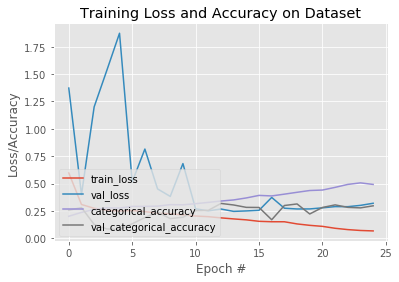

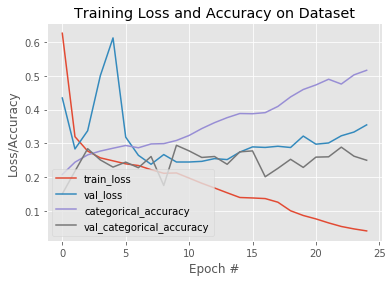

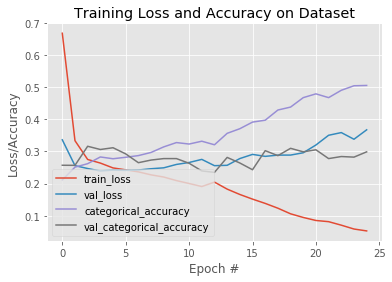

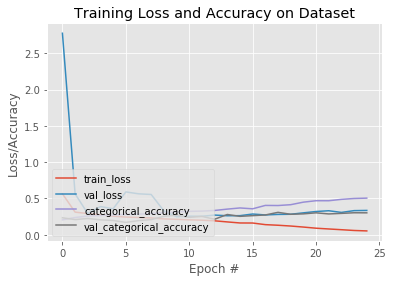

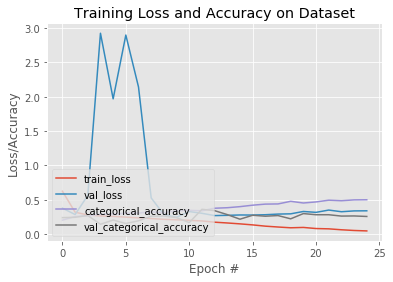

In [20]:
for i in range(5,10):
    BS = 32
    Learning_rate_1 = 0.001
    Learning_rate_2 = 0.0001
    Learning_rate_3 = 0.00001

    NUM_EPOCHS = 25
    EPOCHS = 25
    shape = 224
    name = "224_Small_Sigmoid_"+str(i)+".h5"
    output_dir = "224_Small_Sigmoid_"+str(i)+".pickle"
    save_location = "SpatialVoc2kModels/MultiLabel/"+name

    TRAIN_CSV = "SpatialVoc2k/Training_data_"+str(i)+".csv"
    TEST_CSV = "SpatialVoc2k/Testing_data_"+str(i)+".csv"
    VAL_CSV = "SpatialVoc2k/Validation_data_"+str(i)+".csv"

    NUM_TRAIN_IMAGES = 0
    NUM_TEST_IMAGES = 0
    NUM_VAL_IMAGES = 0

    output_dir = "224_Small_Sigmoid_"+str(i)+".pickle"
    testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES = extract_mlb_multilabel(output_dir,TRAIN_CSV,TEST_CSV,VAL_CSV)
    pickle_dir = "pickle_models/"+output_dir
    mlb = pickle.loads(open(pickle_dir, "rb").read())

    model = train_model_multi("SmallVGG","sigmoid",shape,name,False,NUM_EPOCHS,Learning_rate_1,None,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
    print("[INFO] serializing network...")
    save_location = "SpatialVoc2kModels/MultiLabel/"+name
    model.save(save_location)
    evaluate_model(shape,mlb,BS,model,NUM_TEST_IMAGES,testLabels,TEST_CSV,i)
    K.clear_session()

In [ ]:
model = train_model_multi("SmallVGG","sigmoid",shape,name,False,5,Learning_rate_2,save_location,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
print("[INFO] serializing network...")
save_location = "SpatialVoc2kModels/MultiLabel/"+name
model.save(save_location)
model = train_model_multi("SmallVGG","sigmoid",shape,name,False,5,Learning_rate_3,save_location,mlb,TRAIN_CSV,VAL_CSV,BS,NUM_TRAIN_IMAGES,NUM_VAL_IMAGES)
print("[INFO] serializing network...")
save_location = "SpatialVoc2kModels/MultiLabel/"+name
model.save(save_location)

In [ ]:
#Evalutating SmallVGG 
for i in range(0,10):
    BS = 32
    Learning_rate_1 = 0.001
    Learning_rate_2 = 0.00001
    NUM_EPOCHS = 3
    EPOCHS = 3
    shape = 224
    name = "224_Small_Sigmoid_"+str(i)+".h5"
    output_dir = "224_Small_Sigmoid_"+str(i)+".pickle"
    save_location = "SpatialVoc2kModels/MultiLabel/"+name

    TRAIN_CSV = "SpatialVoc2k/Training_data_"+str(i)+".csv"
    TEST_CSV = "SpatialVoc2k/Testing_data_"+str(i)+".csv"
    VAL_CSV = "SpatialVoc2k/Validation_data_"+str(i)+".csv"

    NUM_TRAIN_IMAGES = 0
    NUM_TEST_IMAGES = 0
    NUM_VAL_IMAGES = 0

    output_dir = "224_Small_Sigmoid_"+str(i)+".pickle"
    testLabels,NUM_TRAIN_IMAGES,NUM_TEST_IMAGES,NUM_VAL_IMAGES = extract_mlb_multilabel(output_dir,TRAIN_CSV,TEST_CSV,VAL_CSV)
    pickle_dir = "pickle_models/"+output_dir
    mlb = pickle.loads(open(pickle_dir, "rb").read())
    model = build_smallvgg(len(mlb.classes_),shape,"sigmoid")
    #model = build_trainable_VGG16(len(mlb.classes_),shape,"sigmoid")
    model.load_weights(save_location)
    evaluate_model(shape,mlb,BS,model,NUM_TEST_IMAGES,testLabels,TEST_CSV,i)

In [19]:
def evaluate_model(shape,mlb,BS,model,NUM_TEST_IMAGES,testLabels,TEST_CSV,number):
    # re-initialize our testing data generator, this time for evaluating
    testGen = csv_image_generator_multilabel_predictor(shape,TEST_CSV, BS)
    #predict_generator(generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
    print("RUNNING PREDICTIONS")
    predictions = model.predict_generator(testGen, steps=NUM_TEST_IMAGES/1,workers=1,use_multiprocessing=True ,verbose=1)
    write_Accuracy(predictions,testLabels,number,mlb)
    predictions = []
    Y_Test = []
    
def write_Accuracy(predictions,Y_Test,number,mlb):
    recalls = get_recalls_for_k(predictions,Y_Test,4,len(mlb.classes_))
    
    row = ["Classes","k = 1 ","k = 2","k = 3","k = 4"]
    rows = []
    rows.append(row)
    for i in range(len(mlb.classes_)):
        row  = [mlb.classes_[i],recalls[0][i],recalls[1][i],recalls[2][i],recalls[3][i]]
        rows.append(row)    
    
    rows.append(["Micro AVG",sum(recalls[0])/len(recalls[0]),sum(recalls[1])/len(recalls[1]),sum(recalls[2])/len(recalls[2]),sum(recalls[3])/len(recalls[3])])
    location = "Spatial_Reports/SMALLVGG_224_Recall"+str(number)+".csv"
    with open(location,"a",newline="") as f1: 
        cw = csv.writer(f1)
        cw.writerows(rows)
    f1.close()
    recalls = []
    rows = []
    predictions = []
    Y_Test = []